In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Data Ingestion and Cleaning

In [2]:
marathon_finish_times = pd.read_csv(".\data\\running_data_2025.csv", index_col='Unnamed: 0')
#marathon_finish_times['finish_time'] = marathon_finish_times['finish_time'].replace('–', '')
#marathon_finish_times['finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'])
#marathon_finish_times['finish_time'] = pd.to_datetime(marathon_finish_times['finish_time'])

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\norri\AppData\Local\Temp\ipykernel_13916\2427503137.py:1: SyntaxWarning: invalid escape sequence '\d'
  marathon_finish_times = pd.read_csv(".\data\\running_data_2025.csv", index_col='Unnamed: 0')


In [3]:
#Move disqualified and did not finish to separate columns and remove from finish_time column
marathon_finish_times.loc[:, 'disqualified'] = marathon_finish_times['finish_time'] == 'DSQ'
marathon_finish_times.loc[:, 'did_not_finish'] = marathon_finish_times['finish_time'] == '–'
#marathon_finish_times.loc[:, 'finish_time'] = marathon_finish_times['finish_time'].replace('–', '').replace('DSQ', '')


# Drop rows with no bib number (only 3)
marathon_finish_times = marathon_finish_times.loc[marathon_finish_times['bib_number'] != '–']

#Change data types
marathon_finish_times['finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'].astype(str), errors='coerce')
marathon_finish_times['bib_number'] = marathon_finish_times['bib_number'].astype(int)
marathon_finish_times['age'] = marathon_finish_times['age'].astype(int)



In [4]:
# Only convert non-NaT timedeltas to minutes, leave NaT as NaN
marathon_finish_times.loc[:,'finish_time'] = pd.to_timedelta(marathon_finish_times['finish_time'])
mask = marathon_finish_times['finish_time'].notna()
marathon_finish_times.loc[mask, 'duration_mins'] = marathon_finish_times.loc[mask, 'finish_time'].dt.total_seconds() / 60

In [5]:
#map age group max and mid points
marathon_finish_times.rename(columns={'age': 'age_min'}, inplace=True)
unique_ages = sorted(marathon_finish_times['age_min'].unique())

age_mapping = {}
for i in range(len(unique_ages) - 1):
    age_mapping[unique_ages[i]] = unique_ages[i + 1] -1
age_mapping[unique_ages[-1]] = None  

marathon_finish_times['age_max'] = marathon_finish_times['age_min'].map(age_mapping)
marathon_finish_times['age_mid'] = (marathon_finish_times['age_min'] + marathon_finish_times['age_max']) / 2

#if 75 we just put these as 75 by default
marathon_finish_times.loc[marathon_finish_times['age_min'] == 75, 'age_max'] = 75
marathon_finish_times.loc[marathon_finish_times['age_min'] == 75, 'age_mid'] = 75


In [6]:
finished_times = marathon_finish_times[mask].copy()

# Statisics

## 1) Hist Plots

### 1a) Overall distribution

In [7]:
x_ticks = range(120,571,60)
y_lim = 700

(0.0, 700.0)

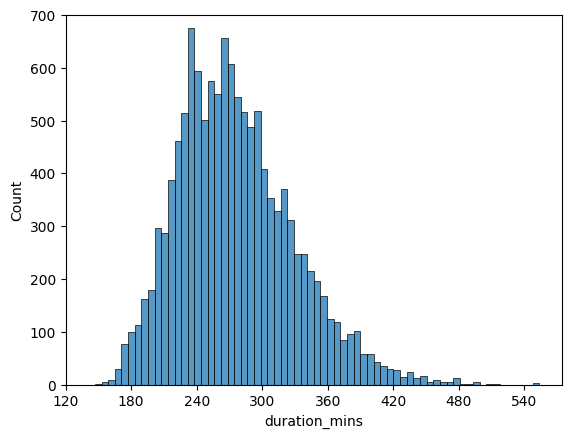

In [8]:
sns.histplot(finished_times, x='duration_mins')
plt.xticks(x_ticks);
plt.ylim(0,y_lim)

### 1b) Overall distribution with peak features added

(0.0, 700.0)

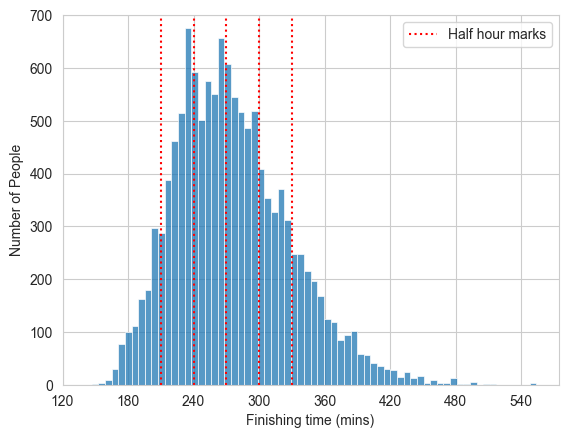

In [9]:
theoretical_peaks = [210, 240, 270, 300, 330]
sns.set_style("whitegrid")
sns.histplot(finished_times, x='duration_mins')
plt.vlines(x=theoretical_peaks, ymin=0, ymax=700, colors='red', linestyles=':')
plt.xticks(x_ticks);
plt.xlabel('Finishing time (mins)')
plt.ylabel('Number of People')
plt.legend(['Half hour marks'])
plt.ylim(0,y_lim)

### 1c) Where do I lie?

In [10]:
me_mask = finished_times['bib_number'] == 36640

In [11]:
finished_times[me_mask]['duration_mins']

5264    278.066667
Name: duration_mins, dtype: float64

(0.0, 700.0)

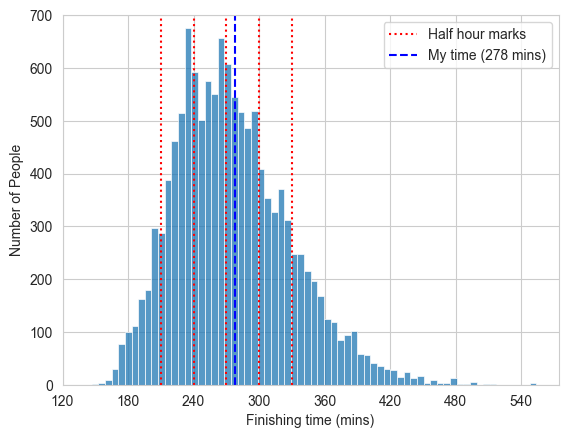

In [12]:
sns.histplot(finished_times, x='duration_mins')
plt.vlines(x=theoretical_peaks, ymin=0, ymax=700, colors='red', linestyles=':')
plt.vlines(x=finished_times[me_mask]['duration_mins'], ymin=0, ymax=700, colors='blue', linestyles='--')
plt.xticks(x_ticks);

plt.xlabel('Finishing time (mins)')
plt.ylabel('Number of People')
plt.legend(['Half hour marks', 'My time (278 mins)'])
plt.ylim(0,y_lim)

In [47]:
finished_times['duration_mins'].median()

269.55

In [48]:
finished_times['duration_mins'].max()

553.9166666666666

## 2) Is it log normal?

In [13]:
finished_times['log_duration_mins'] = np.log(finished_times['duration_mins'])

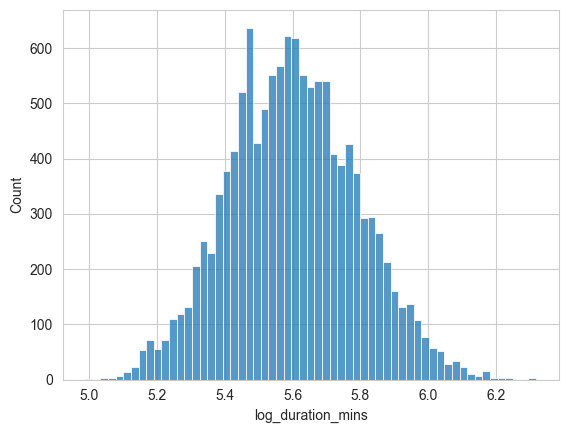

In [14]:
sns.histplot(finished_times, x='log_duration_mins');
sns.set_style("whitegrid")

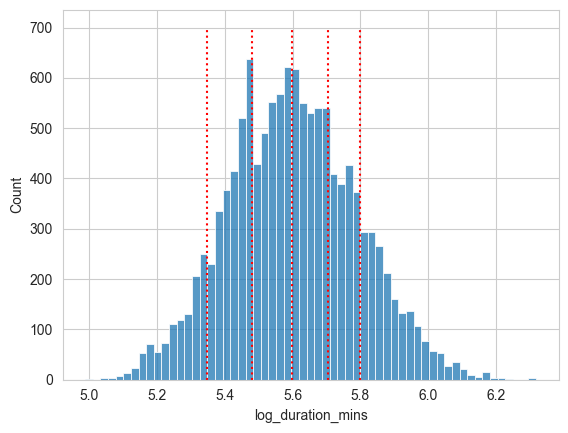

In [15]:
sns.histplot(finished_times, x='log_duration_mins')
plt.vlines(x=np.log(theoretical_peaks), ymin=0, ymax=700, colors='red', linestyles=':');
sns.set_style("whitegrid")

It looks to be log normal minus the peaks around specific times. Therefore we can estimate the mean and std to get a given distribution.

In [16]:
log_mu = finished_times['log_duration_mins'].mean()
log_sigma = finished_times['log_duration_mins'].std()

In [17]:
from scipy.stats import norm, lognorm

In [18]:
print(f"log mean: {log_mu}, \nlog std: {log_sigma}")

log mean: 5.6014030650971955, 
log std: 0.18910338441413085


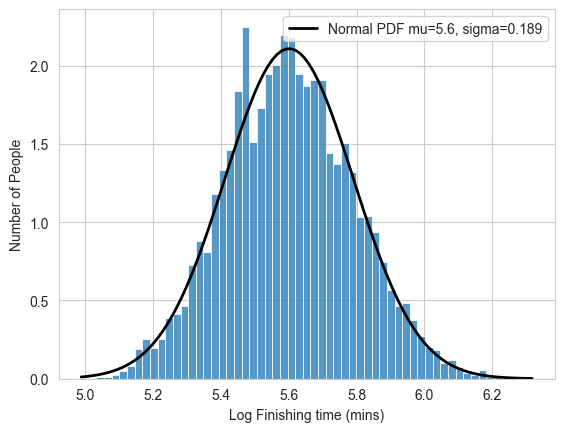

In [19]:
x = np.linspace(finished_times['log_duration_mins'].min(), finished_times['log_duration_mins'].max(), 100)
p = norm.pdf(x, log_mu, log_sigma)
plt.plot(x, p, 'k', linewidth=2, label='Normal PDF')
sns.histplot(finished_times, x='log_duration_mins', stat='density');

plt.xlabel('Log Finishing time (mins)')
plt.ylabel('Number of People')
plt.legend(['Normal PDF mu=5.6, sigma=0.189'])


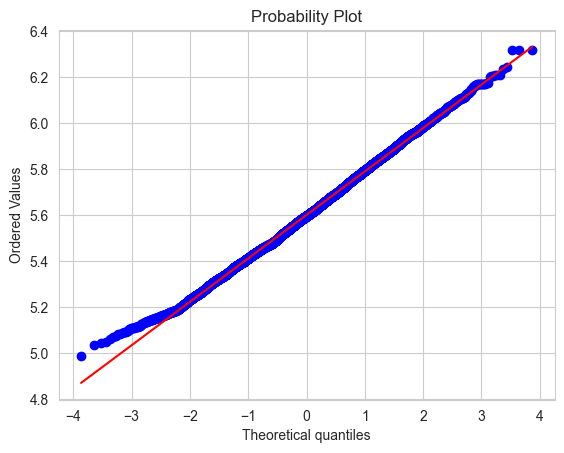

In [20]:
import seaborn as sns
from seaborn_qqplot import pplot
import scipy.stats as stats

stats.probplot(finished_times['log_duration_mins'], dist="norm", plot=plt); 
sns.set_style("whitegrid")

In [21]:
finished_times['log_log_duration_mins'] = np.log(finished_times['log_duration_mins'])

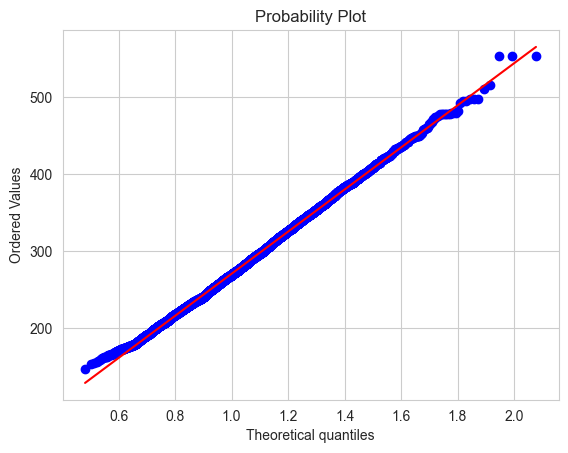

In [22]:
shape, loc, scale = stats.lognorm.fit(finished_times['duration_mins'], floc=0)

stats.probplot(
    finished_times['duration_mins'],
    dist=stats.lognorm,
    sparams=(shape,),
    plot=plt
)
plt.show()
sns.set_style("whitegrid")

In [23]:
shape, loc, scale = stats.lognorm.fit(finished_times['duration_mins'], floc=0)

follows a log normal distribution with mu=5.6014030650971955, sigma=0.18910338441413085


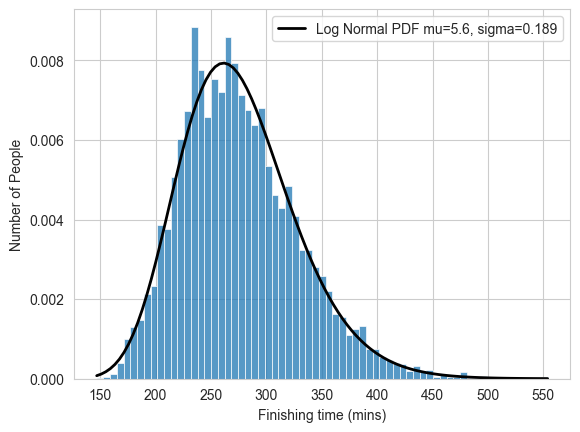

In [24]:
x = np.linspace(finished_times['duration_mins'].min(), finished_times['duration_mins'].max(), 100)

#p = lognorm.pdf(x, log_sigma,loc=0, scale=np.exp(log_mu))
p = lognorm.pdf(x, shape,loc=0, scale=scale)

plt.plot(x, p, 'k', linewidth=2, label='Log Normal PDF')
sns.histplot(finished_times, x='duration_mins', stat='density');

print(f'follows a log normal distribution with mu={log_mu}, sigma={log_sigma}')

plt.xlabel('Finishing time (mins)')
plt.ylabel('Number of People')
plt.legend(['Log Normal PDF mu=5.6, sigma=0.189'])


In [25]:
#KS test
D, p_value = stats.kstest(
    finished_times['duration_mins'],
    'lognorm',
    args=(shape, loc, scale)
)

print(f"KS test statistic: {D}")
print(f"p-value: {p_value}")

KS test statistic: 0.02195637007167983
p-value: 1.0640942545258615e-05


In [26]:
data = finished_times['duration_mins']
shape, loc, scale = stats.lognorm.fit(data, floc=0)
bins = np.linspace(data.min(), data.max(), 10)
observed, _ = np.histogram(data, bins=bins)

# Calculate expected counts
cdf_vals = stats.lognorm.cdf(bins, shape, loc, scale)
expected = np.diff(cdf_vals) * len(data)

# Ensure sums match (fix for numerical precision)
expected = expected * observed.sum() / expected.sum()

# Perform chi-squared test
chi2_stat, p_value = stats.chisquare(observed, f_exp=expected)

print(f"Chi-squared statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value:.4f}")

Chi-squared statistic: 29.70
P-value: 0.0002


## Look at age and sex differences:

In [27]:
counts = finished_times.groupby(['sex', 'age_min']).agg(count = ('bib_number', 'count'))
counts['percentage'] = counts['count']/ finished_times.shape[0]
counts.reset_index(inplace=True)

counts['label'] = counts['sex'] + ' - ' +counts['age_min'].astype('str')

In [28]:
counts.sort_values(by='percentage', ascending=False, inplace=True)

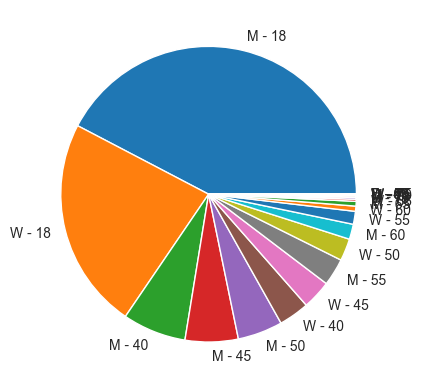

In [29]:
plt.pie(counts['percentage'], labels=counts['label']);

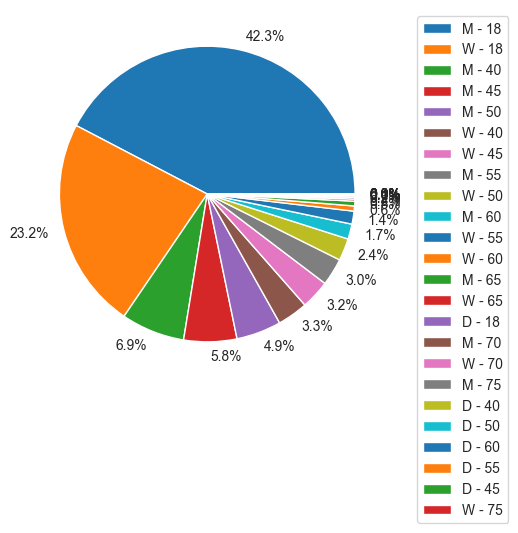

In [30]:
percentages = [f'{p*100:.1f}%' for p in counts['percentage']]

legend_labels = counts['label']

wedges, _ = plt.pie(counts['percentage'], labels=percentages)

plt.legend(wedges, legend_labels, loc='best', bbox_to_anchor=(1.05, 1))

plt.show()

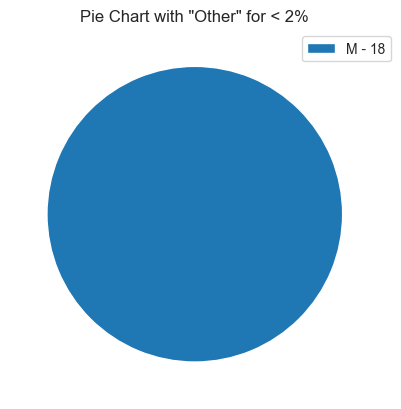

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Set threshold
threshold = 2

# Separate main and other slices
main = counts[counts['percentage'] >= threshold]
other = counts[counts['percentage'] < threshold]

# Combine small slices into "Other"
if not other.empty:
    main = pd.concat([main, pd.DataFrame({
        'label': ['Other'],
        'percentage': [other['percentage'].sum()]
    })])

# Plot the pie chart
plt.pie(main['percentage'], labels=None)  # No labels inside wedges


# Add legend
plt.legend(legend_labels, loc='best', bbox_to_anchor=(1.05, 1))
plt.title('Pie Chart with "Other" for < 2%')
plt.show()

In [32]:
female_mask = finished_times['sex'] == 'W'

def age_mask(min_age: int):
    return finished_times['age_min'] == min_age

In [50]:
finished_times[~female_mask]['duration_mins'].median()

258.56666666666666

In [51]:
finished_times[female_mask]['duration_mins'].median()

291.9583333333333

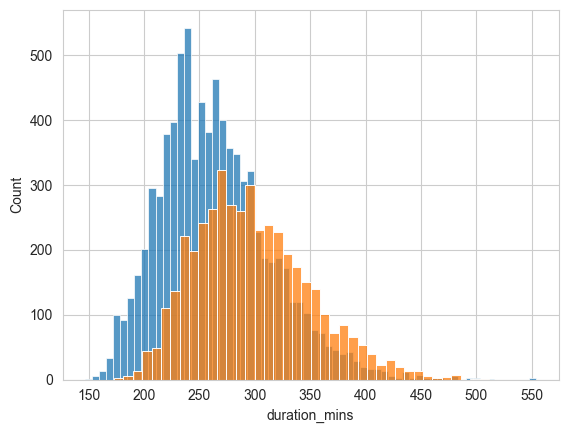

In [34]:
sns.histplot(finished_times[~female_mask], x='duration_mins')
sns.histplot(finished_times[female_mask], x='duration_mins')
plt.show()

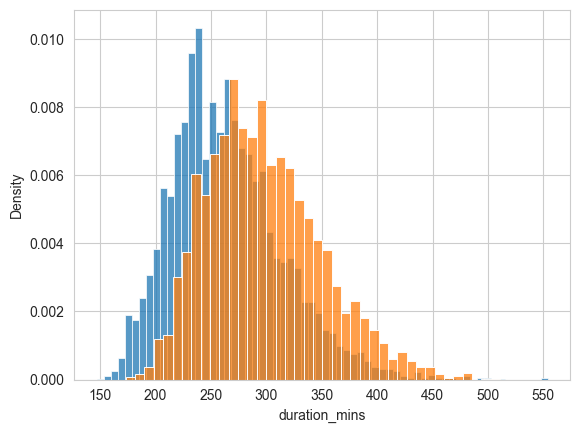

In [35]:
sns.histplot(finished_times[~female_mask], x='duration_mins', stat='density')
sns.histplot(finished_times[female_mask], x='duration_mins', stat='density')
plt.show()

In [36]:
import numpy as np
from scipy.stats import lognorm, kstest

# Example: fitting to your data
data = finished_times[(~female_mask) & (age_mask(18))]['duration_mins'].values

# Fit log-normal parameters (shape, loc, scale)
shape, loc, scale = lognorm.fit(data, floc=0)  # often floc=0 is appropriate

# KS test with fitted parameters
ks_stat, p_value = kstest(data, 'lognorm', args=(shape, loc, scale))
print(f"KS statistic: {ks_stat}, p-value: {p_value}")

KS statistic: 0.03281772490890367, p-value: 1.9350401536963343e-05


In [37]:
finished_times['age_min'].unique()

array([18, 40, 45, 50, 55, 60, 65, 70, 75])

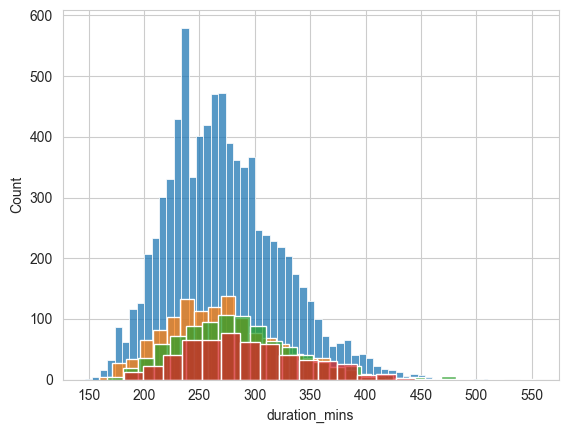

In [38]:
sns.histplot(finished_times[age_mask(18)], x='duration_mins')
sns.histplot(finished_times[age_mask(40)], x='duration_mins')
sns.histplot(finished_times[age_mask(50)], x='duration_mins')
sns.histplot(finished_times[age_mask(55)], x='duration_mins')
#sns.histplot(finished_times[age_mask(60)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(65)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(70)], x='duration_mins', stat='density')
#sns.histplot(finished_times[age_mask(75)], x='duration_mins', stat='density')
plt.show()

<Axes: xlabel='duration_mins', ylabel='Count'>

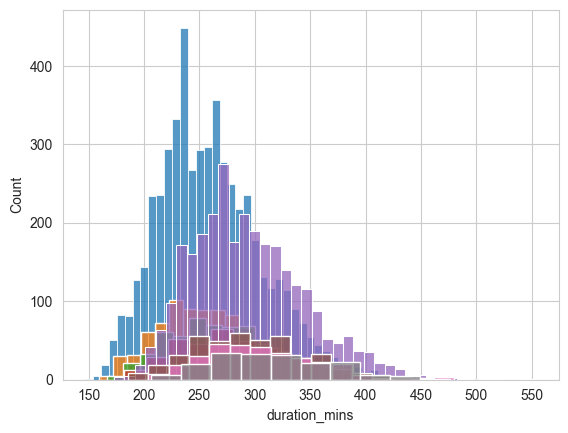

In [39]:
sns.histplot(finished_times[(age_mask(18)) & (~female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(40)) & (~female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(50)) & (~female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(55)) & (~female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(18)) & (female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(40)) & (female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(50)) & (female_mask)], x='duration_mins')
sns.histplot(finished_times[(age_mask(55)) & (female_mask)], x='duration_mins')

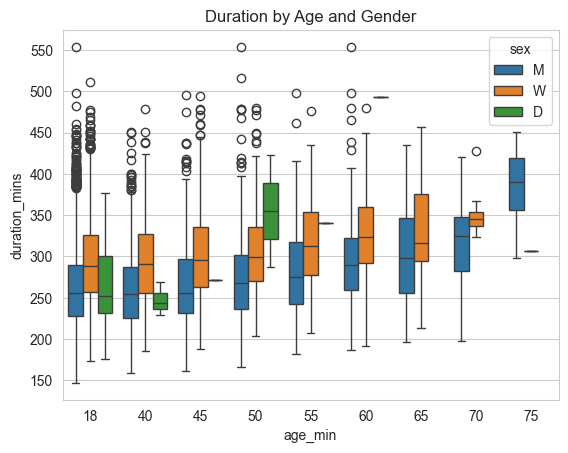

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.boxplot(x='age_min', y='duration_mins', hue='sex', data=finished_times)

plt.title("Duration by Age and Gender")
plt.show()

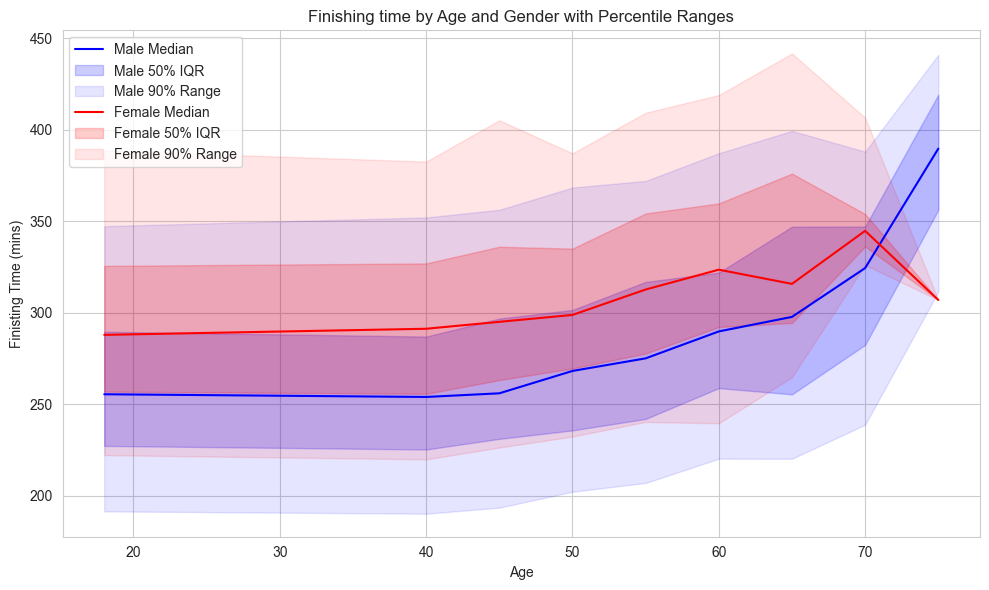

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by age_min and sex to compute required percentiles
summary = finished_times.groupby(['age_min', 'sex'])['duration_mins'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
summary.columns = ['q05', 'q25', 'q50', 'q75', 'q95']
summary = summary.reset_index()

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for Male
male_data = summary[summary['sex'] == 'M']
plt.plot(male_data['age_min'], male_data['q50'], label='Male Median', color='blue')
plt.fill_between(male_data['age_min'], male_data['q25'], male_data['q75'], color='blue', alpha=0.2, label='Male 50% IQR')
plt.fill_between(male_data['age_min'], male_data['q05'], male_data['q95'], color='blue', alpha=0.1, label='Male 90% Range')

# Plot for Female
female_data = summary[summary['sex'] == 'W']
plt.plot(female_data['age_min'], female_data['q50'], label='Female Median', color='red')
plt.fill_between(female_data['age_min'], female_data['q25'], female_data['q75'], color='red', alpha=0.2, label='Female 50% IQR')
plt.fill_between(female_data['age_min'], female_data['q05'], female_data['q95'], color='red', alpha=0.1, label='Female 90% Range')

plt.title("Finishing time by Age and Gender with Percentile Ranges")
plt.xlabel("Age")
plt.ylabel("Finisting Time (mins)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
from scipy.stats import percentileofscore

# Example Series
durations = finished_times[finished_times['sex'] == 'M']['duration_mins']

# Your value
value = int(finished_times[me_mask]['duration_mins'])

# Get the percentile (quantile as a percentage)
percentile = percentileofscore(durations, value)

print(f"Value {value} is at the {percentile:.2f}th percentile")

Value 278 is at the 65.17th percentile


C:\Users\norri\AppData\Local\Temp\ipykernel_13916\1183426685.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value = int(finished_times[me_mask]['duration_mins'])


In [43]:
from scipy.stats import percentileofscore

# Example Series
durations = finished_times['duration_mins']

# Your value
value = int(finished_times[me_mask]['duration_mins'])

# Get the percentile (quantile as a percentage)
percentile = percentileofscore(durations, value)

print(f"Value {value} is at the {percentile:.2f}th percentile")

Value 278 is at the 56.59th percentile


C:\Users\norri\AppData\Local\Temp\ipykernel_13916\972726146.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  value = int(finished_times[me_mask]['duration_mins'])


# Pace tracking

In [44]:
ind_df = pd.read_csv(".\data\\individual_running_data_2025.csv", index_col='Unnamed: 0')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\norri\AppData\Local\Temp\ipykernel_13916\4043353543.py:1: SyntaxWarning: invalid escape sequence '\d'
  ind_df = pd.read_csv(".\data\\individual_running_data_2025.csv", index_col='Unnamed: 0')
C:\Users\norri\AppData\Local\Temp\ipykernel_13916\4043353543.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  ind_df = pd.read_csv(".\data\\individual_running_data_2025.csv", index_col='Unnamed: 0')


In [ ]:

ind_df['diff'] = ind_df['diff.'].apply(
    lambda x: x if x.count(":") == 2 else f"00:{x.strip('-')}"
)


ind_df.loc[:,'split_time'] = pd.to_timedelta(ind_df['diff'], errors='coerce')
ind_df.loc[:,'time'] = pd.to_timedelta(ind_df['Time'], errors='coerce')

ind_clean_df = ind_df[~ind_df['split_time'].isna()].copy()

ind_clean_df.loc[:,'split_time_mins'] = ind_clean_df['split_time'].dt.total_seconds() / 60
ind_clean_df.loc[:,'time_mins'] = ind_clean_df['time'].dt.total_seconds() / 60
#mask = marathon_finish_times['finish_time'].notna()
#marathon_finish_times.loc[mask, 'duration_mins'] = marathon_finish_times.loc[mask, 'finish_time'].dt.total_seconds() / 60

In [ ]:
ind_transposed = pd.DataFrame()

grouped_ind_df = ind_clean_df.groupby('bib_number')[['Split', 'split_time_mins', 'time_mins']]
                                            


for g in grouped_ind_df:

    g_T = g[1].T
    g_T.columns = g_T.iloc[0]     # First row becomes column names
    g_T = g_T[1:]   

    required_columns = ['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K']

    
    if all(col in g_T.columns for col in required_columns):

        try:

            ind_transposed = pd.concat([ind_transposed, pd.DataFrame([{
        'bib_number': g[0], 
        '5k_split': g_T['5K']['split_time_mins'], 
        '10k_split': g_T['10K']['split_time_mins'], 
        '15k_split': g_T['15K']['split_time_mins'], 
        '20k_split': g_T['20K']['split_time_mins'],  
        'Half_split': g_T['Half']['split_time_mins'], 
        '25k_split': g_T['25K']['split_time_mins'] + g_T['Half']['split_time_mins'], 
        '30k_split': g_T['30K']['split_time_mins'], 
        '35k_split': g_T['35K']['split_time_mins'], 
        '40k_split': g_T['40K']['split_time_mins'], 
        'Finish_split': g_T['Finish']['split_time_mins'],
        'full_time': g_T['Finish']['time_mins']
        }])])
            
        except:
            continue



In [ ]:
ind_transposed

,bib_number,5k_split,10k_split,15k_split,20k_split,Half_split,25k_split,30k_split,35k_split,40k_split,Finish_split,full_time
0,12138,23.333333,23.000000,24.400000,24.016667,5.233333,24.050000,25.783333,30.883333,31.933333,12.533333,219.933333
0,12658,27.150000,26.716667,27.300000,26.833333,5.766667,26.416667,26.900000,26.633333,26.533333,10.716667,225.200000
0,12765,29.066667,29.433333,29.250000,31.016667,6.333333,29.066667,29.783333,29.783333,30.300000,13.000000,250.700000
0,13008,22.983333,16.083333,29.416667,22.433333,4.950000,22.666667,23.166667,23.516667,24.616667,10.816667,195.700000
0,13293,29.466667,20.916667,39.500000,29.616667,6.566667,30.833333,30.516667,35.616667,38.183333,16.350000,271.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
0,43887,34.700000,35.233333,35.183333,36.833333,8.966667,40.400000,44.066667,47.883333,44.466667,18.516667,337.283333
0,43888,36.916667,37.883333,38.866667,44.266667,10.116667,47.150000,50.983333,53.350000,52.283333,23.383333,385.083333
0,43890,30.116667,30.433333,31.883333,34.616667,7.783333,41.966667,49.300000,48.000000,46.466667,17.000000,329.783333
0,43894,32.333333,33.133333,38.900000,42.316667,9.316667,44.750000,44.833333,45.366667,46.550000,19.566667,347.750000


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_split_percentiles(df, figure):

    # Define split columns and distances
    split_cols = [
        '5k_split', '10k_split', '15k_split', '20k_split',
        '25k_split', '30k_split', '35k_split', '40k_split'
    ]
    distances = [5, 10, 15, 20, 25, 30, 35, 40]

    # Calculate statistics (convert total time to per-km pace)
    median_times = (df[split_cols].median() / 5).values
    q10 = (df[split_cols].quantile(0.10) / 5).values
    q25 = (df[split_cols].quantile(0.25) / 5).values
    q75 = (df[split_cols].quantile(0.75) / 5).values
    q90 = (df[split_cols].quantile(0.90) / 5).values

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(distances, median_times, marker='o', color='blue', label='Mean Pace')
    plt.fill_between(distances, q25, q75, color='gray', alpha=0.5, label='25th–75th Percentile')
    plt.fill_between(distances, q10, q90, color='lightgray', alpha=0.3, label='10th–90th Percentile')

    plt.xlabel('Distance (km)')
    plt.ylabel('Time per km (minutes)')
    plt.title('Race Splits: Median Pace')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

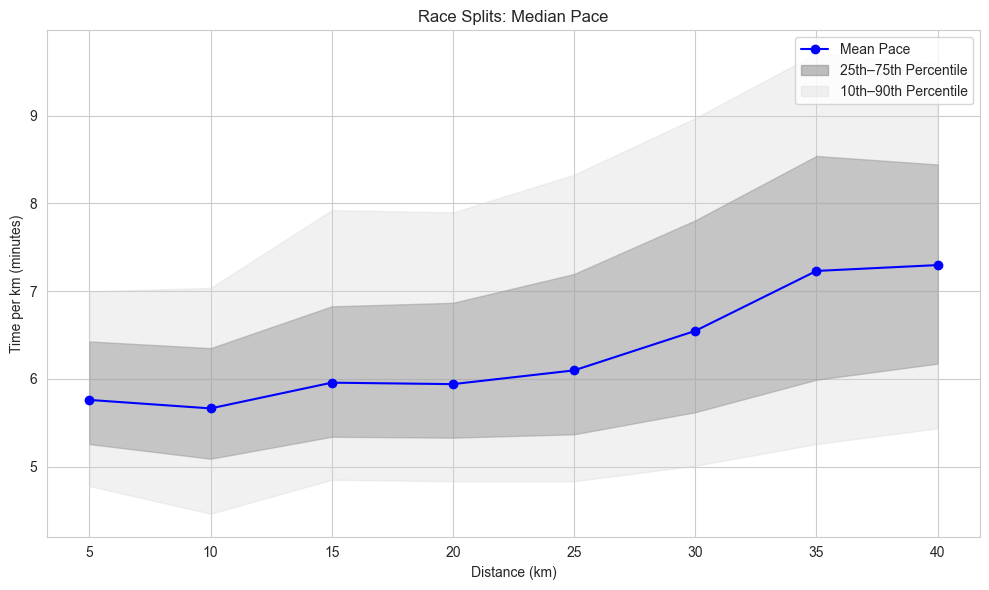

In [ ]:
plot_split_percentiles(ind_transposed)

In [ ]:
ind_transposed

""


In [ ]:
ind_transposed[ind_transposed['full_time'] < 180]

,bib_number,5k_split,10k_split,15k_split,20k_split,Half_split,25k_split,30k_split,35k_split,40k_split,Finish_split,full_time
0,12011,18.150000,18.266667,18.916667,18.583333,4.033333,18.233333,19.466667,21.150000,21.450000,9.450000,163.666667
0,12036,21.300000,21.216667,21.300000,21.133333,4.583333,21.150000,21.250000,21.133333,21.550000,9.400000,179.433333
0,12043,20.616667,20.550000,20.666667,20.616667,4.516667,20.400000,20.966667,20.666667,21.116667,9.350000,174.950000
0,12079,21.133333,20.916667,21.116667,20.950000,4.616667,20.950000,21.133333,21.183333,21.766667,9.300000,178.450000
0,12128,21.433333,21.250000,21.683333,21.050000,4.633333,20.983333,21.316667,21.116667,21.233333,9.083333,179.150000
...,...,...,...,...,...,...,...,...,...,...,...,...
0,27138,19.800000,19.833333,20.033333,19.600000,4.250000,19.166667,20.050000,21.150000,22.866667,10.300000,172.800000
0,27157,19.666667,19.516667,19.483333,19.566667,4.283333,19.633333,19.650000,19.833333,20.383333,8.833333,166.566667
0,27273,18.483333,18.683333,19.883333,19.233333,4.300000,19.500000,19.633333,20.183333,20.850000,9.166667,165.616667
0,27286,19.350000,19.600000,20.700000,20.183333,4.416667,19.983333,20.700000,20.883333,22.600000,9.666667,173.666667


In [ ]:
ind_transposed['full_time'].min()

146.78333333333333

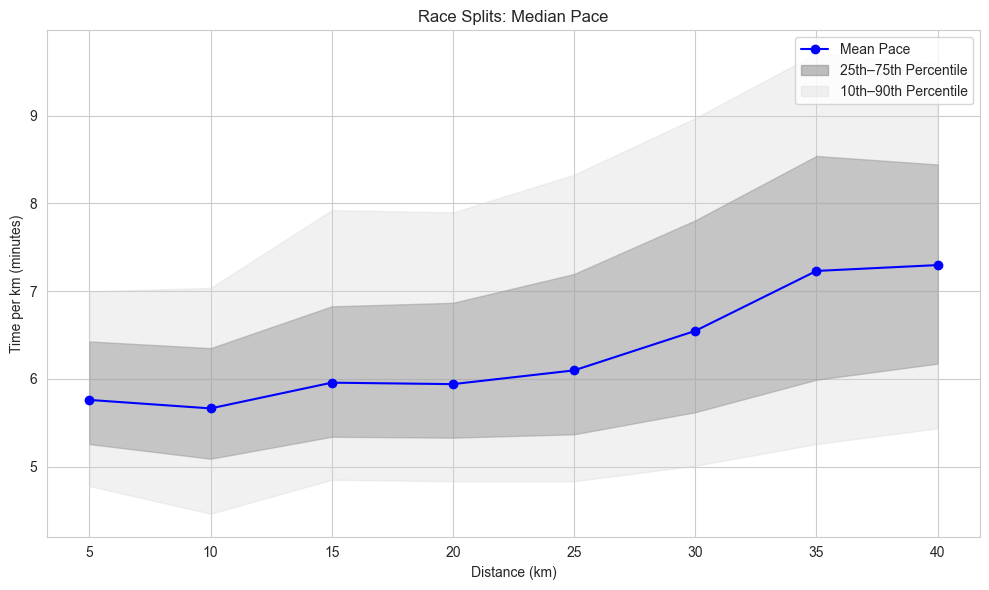

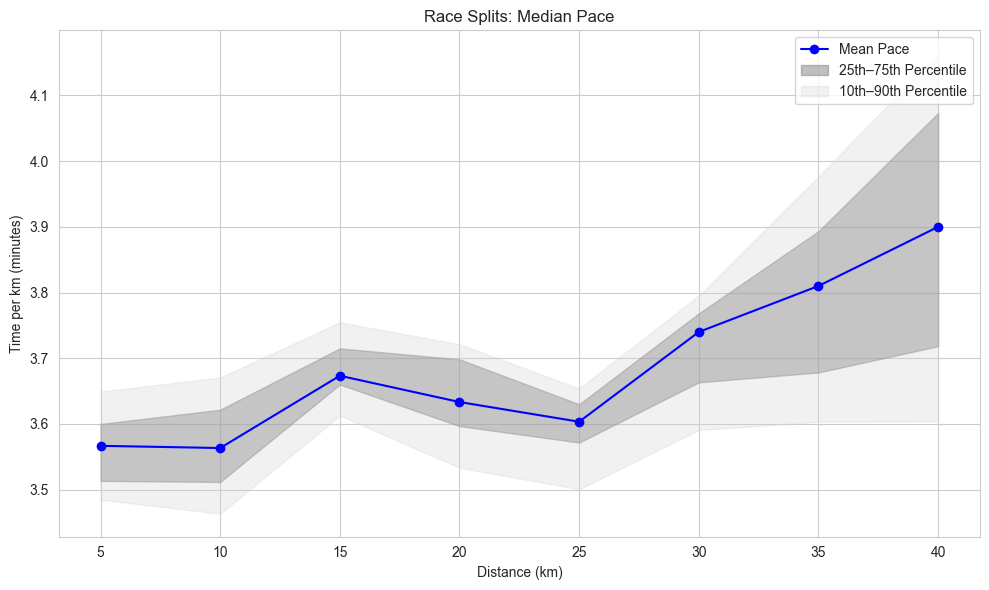

In [ ]:
plot_split_percentiles(ind_transposed)
plot_split_percentiles(ind_transposed[ind_transposed['full_time'] < 160])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_split_percentiles(df, ax, label='Median Pace', color='blue'):
    """
    Plots median split pace with 25–75 and 10–90 percentile bands on the given axis.
    
    Parameters:
    - df: DataFrame containing the split columns
    - ax: matplotlib Axes object to plot on
    - label: Label for the median line
    - color: Color for the line and shading
    """
    
    # Define split columns and distances
    split_cols = [
        '5k_split', '10k_split', '15k_split', '20k_split',
        '25k_split', '30k_split', '35k_split', '40k_split'
    ]
    distances = [5, 10, 15, 20, 25, 30, 35, 40]

    # Calculate pace statistics (per km)
    median_times = (df[split_cols].median() / 5).values
    q10 = (df[split_cols].quantile(0.10) / 5).values
    q25 = (df[split_cols].quantile(0.25) / 5).values
    q75 = (df[split_cols].quantile(0.75) / 5).values
    q90 = (df[split_cols].quantile(0.90) / 5).values

    # Plot onto provided Axes
    ax.plot(distances, median_times, marker='o', color=color, label=label)
    ax.fill_between(distances, q25, q75, color=color, alpha=0.3)
    #ax.fill_between(distances, q10, q90, color=color, alpha=0.15)

    # Axis formatting
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time per km (minutes)')
    ax.set_title('Race Splits: Median Pace')
    ax.grid(True)

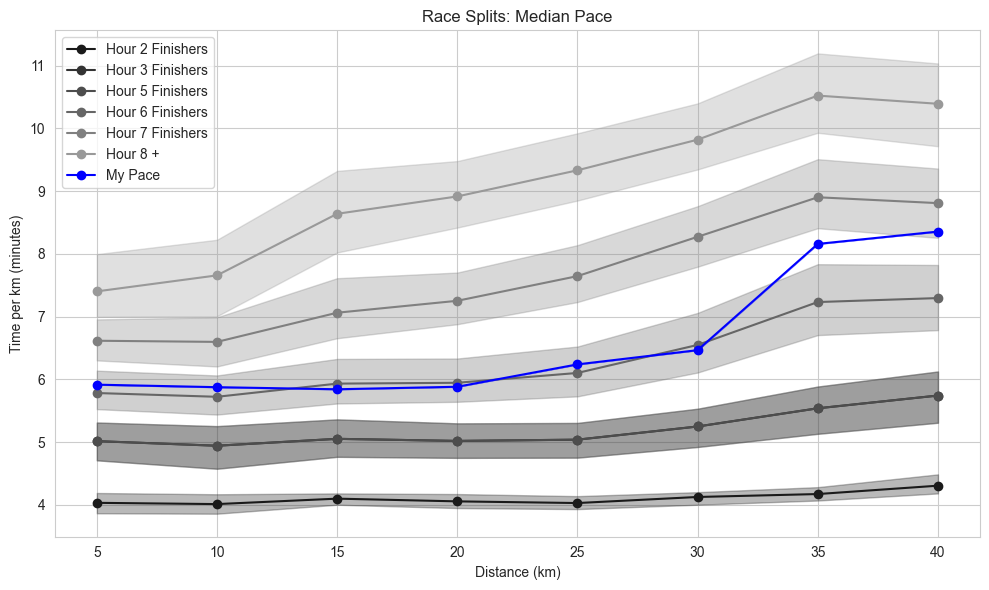

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
#lot_split_percentiles(ind_transposed)

plot_split_percentiles(ind_transposed[(ind_transposed['full_time'] < 180)], ax, label=' Sub 3 Finishers', color='0.1')
plot_split_percentiles(ind_transposed[(ind_transposed['full_time'] > 180) & (ind_transposed['full_time'] < 240)], ax, label='3-4 Finishers', color='0.2')
plot_split_percentiles(ind_transposed[(ind_transposed['full_time'] > 240) & (ind_transposed['full_time'] < 300)], ax, label='4-5 Finishers', color='0.4')
plot_split_percentiles(ind_transposed[(ind_transposed['full_time'] > 300) & (ind_transposed['full_time'] < 360)], ax, label='5-6 Finishers', color='0.5')
plot_split_percentiles(ind_transposed[(ind_transposed['full_time'] > 360)], ax, label='6+ Hour Finishers', color='.6')
plot_split_percentiles(ind_transposed[(ind_transposed['bib_number'] == '36640')], ax, label='My Pace', color='blue')

ax.legend()
plt.tight_layout()
plt.show()

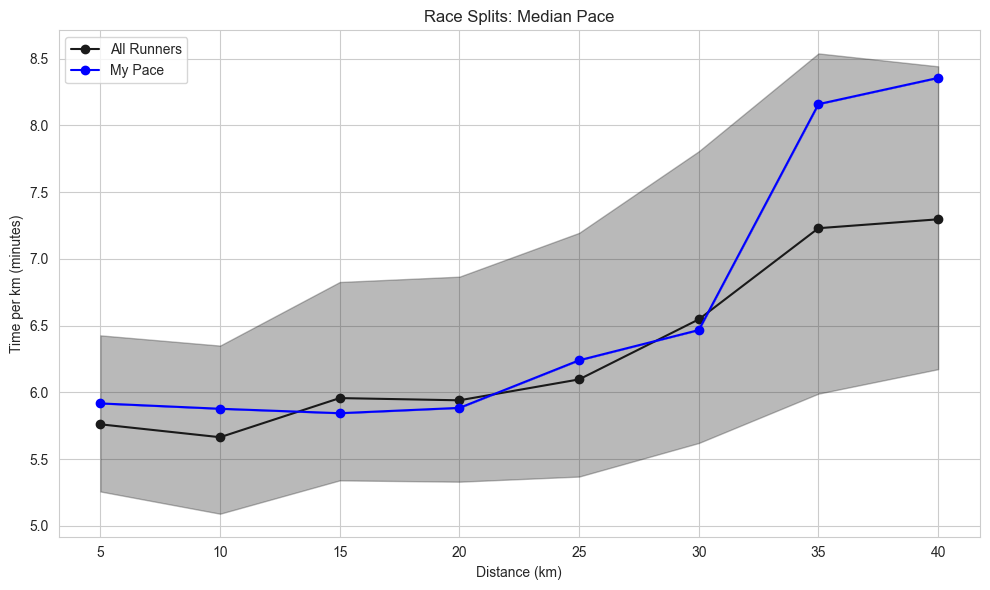

In [290]:

fig, ax = plt.subplots(figsize=(10, 6))
plot_split_percentiles(ind_transposed, ax, label='All Runners', color='0.1')
plot_split_percentiles(ind_transposed[(ind_transposed['bib_number'] == '36640')], ax, label='My Pace', color='blue')

ax.legend()
plt.tight_layout()
plt.show()

In [262]:
ind_transposed

,bib_number,5k_split,10k_split,15k_split,20k_split,Half_split,25k_split,30k_split,35k_split,40k_split,Finish_split,full_time
0,12138,23.333333,23.000000,24.400000,24.016667,5.233333,24.050000,25.783333,30.883333,31.933333,12.533333,219.933333
0,12658,27.150000,26.716667,27.300000,26.833333,5.766667,26.416667,26.900000,26.633333,26.533333,10.716667,225.200000
0,12765,29.066667,29.433333,29.250000,31.016667,6.333333,29.066667,29.783333,29.783333,30.300000,13.000000,250.700000
0,13008,22.983333,16.083333,29.416667,22.433333,4.950000,22.666667,23.166667,23.516667,24.616667,10.816667,195.700000
0,13293,29.466667,20.916667,39.500000,29.616667,6.566667,30.833333,30.516667,35.616667,38.183333,16.350000,271.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
0,43887,34.700000,35.233333,35.183333,36.833333,8.966667,40.400000,44.066667,47.883333,44.466667,18.516667,337.283333
0,43888,36.916667,37.883333,38.866667,44.266667,10.116667,47.150000,50.983333,53.350000,52.283333,23.383333,385.083333
0,43890,30.116667,30.433333,31.883333,34.616667,7.783333,41.966667,49.300000,48.000000,46.466667,17.000000,329.783333
0,43894,32.333333,33.133333,38.900000,42.316667,9.316667,44.750000,44.833333,45.366667,46.550000,19.566667,347.750000


In [ ]:
ind_transposed[(ind_transposed['bib_number'] == '36640')]


,bib_number,5k_split,10k_split,15k_split,20k_split,Half_split,25k_split,30k_split,35k_split,40k_split,Finish_split,full_time
0,36640,29.583333,29.383333,29.216667,29.416667,6.5,31.2,32.333333,40.8,41.783333,14.35,278.066667
